In [1]:
import sys
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/gaussfiltax')

import time

from jax import numpy as jnp
from jax import random as jr
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
# import tensorflow as tf
# tf.test.gpu_device_name()

import gaussfiltax.utils as utils
import gaussfiltax.inference as gf
from gaussfiltax.models import ParamsNLSSM, NonlinearSSM, ParamsBPF

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Models and simulations

In [2]:
# Parameters
state_dim = 4
state_noise_dim = 2
emission_dim = 1
emission_noise_dim = 1
seq_length = 100
mu0 = 1.0 * jnp.array([-0.05, 0.001, 0.7, -0.05])
q0 = jnp.zeros(state_noise_dim)
r0 = jnp.ones(emission_noise_dim)
Sigma0 = 1.0 * jnp.array([[0.1, 0.0, 0.0, 0.0],[0.0, 0.005, 0.0, 0.0],[0.0, 0.0, 0.1, 0.0],[0.0, 0.0, 0.0, 0.01]])
Q = 1e-6 * jnp.eye(state_noise_dim)
R = 1e-6 * jnp.eye(emission_noise_dim)

F = jnp.array([[1, 1, 0, 0],[0, 1, 0, 0],[0, 0, 1, 1],[0, 0, 0, 1]])
G = jnp.array([[0.5, 0],[1, 0],[0, 0.5],[0, 1]])
fBOT = lambda x, q, u: F @ x + G @ q
gBOT = lambda x, r, u: jnp.arctan2(x[2], x[0]) + r
gBOTlp = lambda x, y, u: MVN(loc = gBOT(x, 0.0, u), covariance_matrix = R).log_prob(y)
inputs = jnp.zeros((seq_length, 1))

In [3]:
f = fBOT
g = gBOT
glp = gBOTlp

In [4]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
)

## Experiments

In [5]:
verbose = False
Nsim = 10
gsf_rmse = jnp.zeros(Nsim)
agsf_rmse = jnp.zeros(Nsim)
bpf_rmse = jnp.zeros(Nsim)
gsf_norm = jnp.zeros((Nsim, seq_length))
agsf_norm = jnp.zeros((Nsim, seq_length))
bpf_norm = jnp.zeros((Nsim, seq_length))
next_key = jr.PRNGKey(10)
for i in range(Nsim):
    print('sim {}/{}'.format(i+1, Nsim))
    # Generate Data
    key, next_key = jr.split(next_key)
    states, emissions = model.sample(params, key, seq_length, inputs = inputs)
    

    # GSF
    M = 5
    tin = time.time()
    posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, M, 1, inputs)
    point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
    tout = time.time()
    print('       Time taken for GSF: ', tout - tin)

    # AGSF
    tin = time.time()
    num_components = [M, 5, 5] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check internal containers._branch_from_node
    posterior_filtered_agsf, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = (0.8, 0.01), inputs=inputs)    
    point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
    tout = time.time()
    print('       Time taken for AGSF: ', tout - tin)

    # BPF
    tin = time.time()
    num_particles = 100

    params_bpf = ParamsBPF(
        initial_mean=mu0,
        initial_covariance=Sigma0,
        dynamics_function=f,
        dynamics_noise_bias=q0,
        dynamics_noise_covariance=Q,
        emission_function=g,
        emission_noise_bias=r0,
        emission_noise_covariance=R,
        emission_distribution_log_prob = glp
    )

    posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs)
    point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
    tout = time.time()
    print('       Time taken for BPF: ', tout - tin)

    # Computation of errors
    gsf_rmse = gsf_rmse.at[i].set(utils.rmse(point_estimate_gsf, states))
    agsf_rmse = agsf_rmse.at[i].set(utils.rmse(point_estimate_agsf, states))
    bpf_rmse = bpf_rmse.at[i].set(utils.rmse(point_estimate_bpf, states))

    print('              GSF RMSE:', gsf_rmse[i])
    print('              AGSF RMSE:', agsf_rmse[i])
    print('              BPF RMSE:', bpf_rmse[i])

    gsf_norm = gsf_norm.at[i].set(jnp.linalg.norm(point_estimate_gsf - states, axis = 1))
    agsf_norm = agsf_norm.at[i].set(jnp.linalg.norm(point_estimate_agsf - states, axis = 1))
    bpf_norm = bpf_norm.at[i].set(jnp.linalg.norm(point_estimate_bpf - states, axis = 1))


    fig, axes = plt.subplots(2, 1, sharex=False, figsize=(10, 7))
    fig.tight_layout(pad=3.0)
    axes[0].scatter(states[:,0], states[:,2], label = 'True', s = 1)
    axes[0].scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 1)
    axes[0].scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 1)
    axes[0].scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 1)
    axes[0].legend()   

    axes[1].plot(emissions, label = 'Emissions')
    axes[1].legend()

    plt.show()


sim 1/10
       Time taken for GSF:  0.35975074768066406


In [ ]:
ind = jnp.argwhere(jnp.isnan(gsf_norm[:,99])).flatten()
gsf_norm = jnp.delete(gsf_norm, ind, axis = 0)

In [ ]:
import pandas as pd
gsf_armse = jnp.mean(gsf_rmse)
agsf_armse = jnp.mean(agsf_rmse[1:])
bpf_armse = jnp.mean(bpf_rmse)

gsf_tab_out = '{:10.2f}±{:10.2f}'.format(gsf_armse, jnp.std(gsf_rmse))
agsf_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_armse, jnp.std(agsf_rmse))
bpf_tab_out = '{:10.2f}±{:10.2f}'.format(bpf_armse, jnp.std(bpf_rmse))

# gsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(gsf_atime, np.std(gsf_time))
# agsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(agsf_atime, np.std(agsf_time))
# bpf_tab_out1 = '{:10.2f}±{:10.2f}'.format(bpf_atime, np.std(bpf_time))

df = pd.DataFrame(columns = [' ','RMSE','time(s)'])
df[' '] = ['GSF', 'AGSF', 'BPF']
df['RMSE'] = [gsf_tab_out, agsf_tab_out, bpf_tab_out]
#  df['time(s)'] = [gsf_tab_out1, agsf_tab_out1, bpf_tab_out1]
print(df.to_latex(index=False))  
df

\begin{tabular}{lll}
\toprule
  & RMSE & time(s) \\
\midrule
GSF &        nan±       nan & NaN \\
AGSF &      54.84±     56.45 & NaN \\
BPF &      10.79±      5.62 & NaN \\
\bottomrule
\end{tabular}



,,RMSE,time(s)
0,GSF,nan± nan,NaN
1,AGSF,54.84± 56.45,NaN
2,BPF,10.79± 5.62,NaN


## Plots

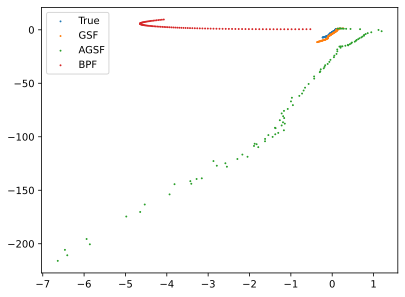

In [ ]:
plt.scatter(states[:,0], states[:,2], label = 'True', s = 1)
plt.scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 1)
plt.scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 1)
plt.scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 1)
plt.legend()   
plt.show()